# World3 Hands On
In this notebook, you will see how society can be represented by inter-related socio-economic variables and thier projections into the future. This tutorial will provide insights into the pressing socioeconomic issues related to climate change, such as resource scarcity, population dynamics, and the potential impacts of unchecked resource extraction. In particular, you will see some socioeconomic projections of the Integrated Assessment Modelling (IAM) used by the IPCC, and the influence of shared socio-economic pathways on these projections. In the bulk of the tutorial, you will use the `World3` model, a tool developed in the 1970s to analyze potential economic and population scenarios. You will use it to learn about nonlinear, coupled dynamics of various aggregated world system variables and how this model informs modern day climate challenges.

# Setup



In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install -q condacolab
# import condacolab
# condacolab.install()

# !mamba install pyworld3

In [2]:
# imports
from IPython.display import Math
from IPython.display import display, HTML, Image
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
import pooch
import os
import tempfile
import urllib
from pyworld3 import World3
from pyworld3.utils import plot_world_variables

##  Figure settings


In [3]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

sns.set_style("ticks", {"axes.grid": False})
%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
params = {"lines.linewidth": "3"}
plt.rcParams.update(params)

##  Helper functions


In [4]:
# @title Helper functions


def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

def get_IPCC_data(var_name, path):
    IAMdf = pd.read_excel(path)
    IAMdf.drop(
        IAMdf.tail(2).index, inplace=True
    )  # excel file has 2 trailing rows of notes
    IAMdf.drop(
        ["Model", "Region", "Variable", "Unit", "Notes"], axis=1, inplace=True
    )  # remove columns we won't need

    # The data is in wideform (years are columns).
    # Longform (year of each datum as a column) is more convenient.
    # To collapse it to longform we'll use the `pd.wide_to_long` method that requires the following reformatting
    IAMdf.rename(
        columns=dict(
            zip(IAMdf.columns[1:], [var_name + str(y) for y in IAMdf.columns[1:]])
        ),
        inplace=True,
    )  # add 'pop' to the year columns to tell the method which columns to map
    IAMdf.index = IAMdf.index.set_names(["id"])  # name index
    IAMdf = IAMdf.reset_index()  # make index a column
    IAMdf = pd.wide_to_long(IAMdf, [var_name], i="id", j="year")

    IAMdf = IAMdf.reset_index().drop("id", axis=1)  # do some post mapping renaming
    IAMdf.year = IAMdf.year.apply(int)  # turn year data from string to int
    if var_name == "pop":
        IAMdf[var_name] = 1e6 * IAMdf[var_name]  # pop is in millions
    elif var_name == "CO2":
        IAMdf[var_name] = 1e6 * IAMdf[var_name]  # CO2 is in Mt CO2/yr
    elif var_name == "forcing":
        IAMdf = IAMdf  # forcing in W/m2
    return IAMdf


def run_and_plot(world3, nri_factor=1, new_lifetime_industrial_capital=14):
    # nonrenewable resources initial [resource units]
    world3.init_world3_constants(
        nri=nri_factor * 1e12, alic1=14, alic2=new_lifetime_industrial_capital
    )
    world3.init_world3_variables()
    world3.set_world3_table_functions()
    world3.set_world3_delay_functions()
    world3.run_world3(fast=False)

    # select model variables to plot
    variables = [
        world3.nrfr,
        world3.iopc,
        world3.fpc,
        world3.pop,
        world3.ppolx,
        world3.d,
        world3.cdr,
    ]
    variable_labels = [
        "Resource",  # nonrenewable resource fraction remaining (NRFR)
        "Industry",  # industrial output per capita [dollars/person-year] (IOPC)
        "Food",  # food production per capita [vegetable-equivalent kilograms/person-year] (FPC)
        "Population",  # population [persons] (POP)
        "Pollution",  # index of persistent pollution (PPOLX)
        # (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
        "Deaths",
        "Deathrate\n/1000",
    ]
    variable_limits = [
        [0, 1],
        [0, 1e3],
        [0, 1e3],
        [0, 16e9],
        [0, 32],
        [0, 5e8],
        [0, 250],
    ]  # y axis ranges

    plot_world_variables(
        world3.time,
        variables,
        variable_labels,
        variable_limits,
        img_background=None,  # ./img/fig7-7.png",
        figsize=[4 + len(variables), 7],
        title="initial non-renewable resources=" + str(nri_factor) + "*1e12",
        grid=True,
    )

    # overlay an SSP projection
    scenario_name = "SSP2-Baseline"
    pop_path = pooch.retrieve("https://osf.io/download/ed9aq/", known_hash=None)
    IAMpopdf = get_IPCC_data("pop", pop_path)
    year_data = IAMpopdf.loc[IAMpopdf.Scenario == scenario_name, "year"]
    var_data = IAMpopdf.loc[IAMpopdf.Scenario == scenario_name, "pop"]
    axs = plt.gcf().axes
    axs[variable_labels.index("Population")].plot(
        year_data, var_data, "r--", label=scenario_name
    )
    axs[variable_labels.index("Population")].legend(frameon=False)

##  Video 1: The Socio-economic Origins of the Climate Emergency


In [5]:
# @title Video 1: The Socio-economic Origins of the Climate Emergency

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'q0vzG9eVUYs'), ('Bilibili', 'BV1tV411T7DK')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [6]:
 # @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "rqmf2"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Exploring the IPCC's Socioeconomic Scenarios

In this, and subsequent, tutorials, you will explore Integrated Assessment Models (IAMs) which are the standard class of models used to make climate change projections. IAMs couple a climate model to an economic model, allowing us to evaluate the two-way coupling between economic productivity and climate change severity. IAMs can also account for changes that result from mitigation efforts, which lessen anthropogenic emissions. In other words, IAMs are models that link human economic activity with climate change. 

Let's start by investigating some IAM model output, which will prepare you to explore `World3` (which gives similar socioeconomic output) later in this tutorial.

All data from the main simulations of the IAMs used in the IPCC reports is freely available for viewing [here](https://tntcat.iiasa.ac.at/SspDb/dsd). The simulations are labeled by both the Shared Socioeconomic Pathway (SSP1, SSP2, SSP3, SSP4, and SSP5) and the forcing level (greenhouse gas forcing of 2.6, 7.0, 8.5 W m<sup>2</sup> etc. by 2100). The 5 SSPS are: 
- SSP1: Sustainability (Taking the Green Road)
- SSP2: Middle of the Road
- SSP3: Regional Rivalry (A Rocky Road)
- SSP4: Inequality (A Road divided)
- SSP5: Fossil-fueled Development (Taking the Highway)
You will learn more about how these 5 SSPs were determined in future tutorials.

In previous days, you have looked at climate model data for projections of sea surface temperature change under different SSPs. We saw that applying different greenhouse gas forcings to a climate model affects global temperature projections and also influences other parts of the climate system, such as precipitation. In this section, we will take a look at the modelled socio-economic impacts associated with such changes to the physical climate system.

It is possible to download the IAM data if you provide an email address, but for this tutorial the following files have already been downloaded:

- Climate forcing
- World population
- Total CO<sub>2</sub> emissions

Since the files all have the same name, `iamc_db.xlsx`, we have added '_forcing', '_pop', and '_CO2' to differentiate the files and have stored them in our OSF repository. 

Let's load and plot this data to explore the forcing, population and CO<sub>2</sub> emissions across the different SSP scenarios. You can utilize the pre-defined plotting function from above.

SHA256 hash of downloaded file: 6cb9ecdcc8cd89e6b2c6438ed0f60a9afe4791e6fc4190b3a190da32242897a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 8ebe2fb8e0085e4382ff49dc1a68c6aca619d4490a0c8853c75c0d2e6db621e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: ed904c795d69abd36e94758a5a2bb4b63caec7da9ef02f782f62c53bfd2bc23f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
c:\Users\jajohns\mambaforge\envs\env2023a\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\jajohns\mambaforge\envs\env2

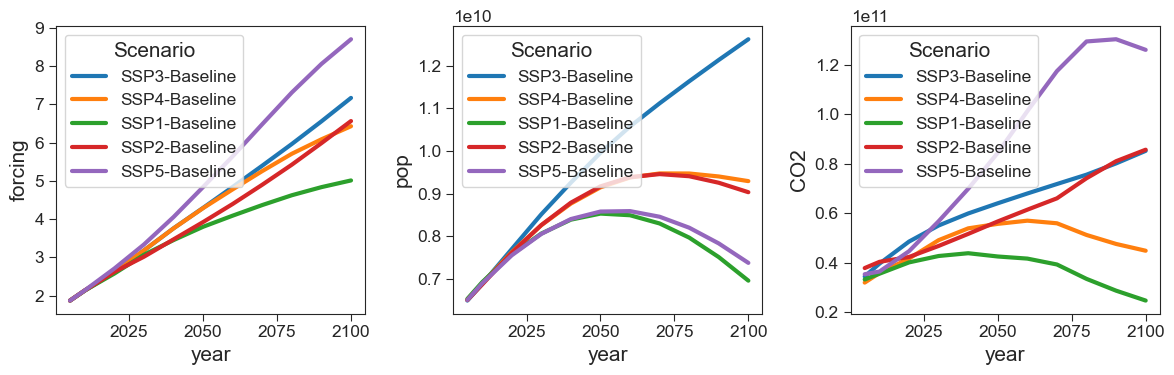

In [7]:
var_names = ["forcing", "pop", "CO2"]
filenames = ["iamc_db_forcing.xlsx", "iamc_db_pop.xlsx", "iamc_db_CO2.xlsx"]
paths = [
    "https://osf.io/download/tkrf7/",
    "https://osf.io/download/ed9aq/",
    "https://osf.io/download/gcb79/",
]
files = [pooch_load(path, filename) for path, filename in zip(paths, filenames)]
axis_size = 4
fig, ax = plt.subplots(
    1, len(var_names), figsize=(axis_size * len(var_names), axis_size)
)
for ax_idx, var_name in enumerate(var_names):
    data_df = get_IPCC_data(var_name, files[ax_idx])
    sns.lineplot(
        ax=ax[ax_idx], data=data_df, x="year", y=var_name, hue="Scenario"
    )  # plot the data

The projections in the plots you just created show changes in climate forcing (left), population (middle) and CO<sub>2</sub> emissions (right) across the five different SSP scenarios computed at thier baseline forcing level (different for each scenario), which are each represented by a distinct color in each plot.

The projections for each SSP are created by optimizing economic activity within the constraint of a given level of greenhouse gas forcing at 2100. This activity drives distinct temperature changes via the emissions it produces, which are inputted into a socioeconomic model component to compute economic damages. These damages feedback into the model to limit emissions-producing economic activity. The forcing constraint ensures the amount of emissions produced is consistent for that particular scenario. In other words, the projected temperature change under different scenarios is fed to a socioeconomic model component in order to assess the socioeconomic impacts resulting from the temperature change associated with each SSP.

Not every variable in IAMs is endogenous (i.e. determined by other variables in the model). Some variables, like population or technology growth, are exogeneous (i.e. variables whose time course is given to the model). In this case, the time course of population and economic growth, are derived from simple growth models. 

### Questions 1

1. Having watched the video on the limits of growth, why might the continued growth in both population and economy not be assured?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/solutions/W2D3_Tutorial1_Solution_b081dd60.py)



# Section 2: World Models and `World3`
In this section you will take a step back from IAMs and use another model class, *world models*, to first explore how socioeconomic system variables like population, capital and pollution co-vary. You've already seen world models in the video for this tutorial, but let's recap what they are and why they are interesting.


World models are computational models that incorporate natural physical limits in the economy. For example, world models can help to assess the impact of an economy based on growth-oriented extraction of a finite resource. All variables in world model are endogeneous. Recall that endogeneous variables determined by other variables in the model, rather than being given to the model. Therefore, world models are self-contained and simply run as a dynamical system: given an initial condition (a value for all variables) and the equations describing rates of change of the variables, they output the subsequent time series of these variables. The important variables in a world model are similar to those of Integrated Assessment Models: capital, production, population, pollution etc. 

`World3` is a world model that was developed in the 1970s and doesn't have an explicit climate component (perhaps its developers were unaware of climate change at the time, as many were back then). However, `World3` does have a *pollution* variable that is driven by industrial activity, and this pollution negatively impacts food production and directly increases mortality rates via health effects. If we were developing `World3` today with our knowledge of human-driven climate change, we would add greenhouse gas emissions as a component of the pollution variable, which is the place in `World3` representing the damaging waste of our industrial activity.  

The reason we are looking at `World3` here in this first tutorial, is that:
1. `World3` is an instructive world model of the resource depletion and pollution problem. It is essential to understand the forcings, feedbacks and results associated with these problems because they directly contribute to climate change. More specifically, understanding these problems helps us understand the socioeconomic forces driving the emissions that are the source of the climate change problem.
2. World models provide an alternative modelling tradition not steeped in the neoclassical economics on which IAMs are based. This provides some diversity in perspective.

*Note: the model in `World3` is not only wrong (i.e. missing many variables), but is a poor idealization. In other words, the `World3` model is not necessarily qualitatively predictive because it is missing some determining variables/model features (e.g. technology innovation/adaptation). It is thus almost certainly not predictive, but is still useful for thinking about 'world systems' because it includes important relationships between some key natural and socio-economic variables that we will look at here. In later tutorials, we will learn about similr critiques of elements of IAMs (e.g. for lacking important variables).*

Now that we have a basic understanding of World3, we can start to explore some more specific components and interactions of the model. 

Welcome to World3! If you are interested in the full model flow chart please reference Meadows, D.L.; Behrens, W.W.; Meadows, D.L.; Naill, R.F.; Randers, J.; Zahn, E.K.O. The Dynamics of Growth in a Finite World; Wright-Allen Press: Cambridge, MA, USA, 1974. Source: https://www.mdpi.com/sustainability/sustainability-07-09864/article_deploy/html/images/sustainability-07-09864-g001.png

For the purposes of this tutorial, here is a reduced diagram adapted from Limits To Growth (1972, page 97) containing only some major variables in the model and their couplings:

![world3 map](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D3_FutureClimate-IPCCII%26IIISocio-EconomicBasis/images/world3_major_flows.png?raw=true)


This image can be used to follow a *pathway* describing the flow of model variable dependencies to gain insight into how the model works (note this use of the word 'pathway' is distinct from that in 'socioeconomic pathways'). When a pathway comes back to itself, this is a termed a feedback pathway (or feedback loop) by which changes can be amplified or attenuated by the way the model couples distinct variables. Recall from W1D1 that there are two types of feedbacks: positives feedbacks (change in variable A causes a change in variable B, which in turn causes a change in variable A in the same direction as the initial change) and negative feedbaks (change in variable A causes a change in variable B, which in turn causes a change in variable A in the opposite direction as the initial change). 

Let's look at some important feedback pathways in the model that appear in this image (also see pg. 95 of [Limits of growth](http://www.donellameadows.org/wp-content/userfiles/Limits-to-Growth-digital-scan-version.pdf)): 
- The two positive feedback loops involving births and investment generate the exponential growth behavior of population and capital, respectively.
    - Investment drives industrial capital which drives industrial output which drives investment.
    - Population drives births drives population.
- The two negative feedback loops involving deaths and depreciation tend to regulate this exponential growth.
    - Industrial capital drives up depreciation which lowers industrial capital.
    - Population drives deaths which lowers population.

There is a clear and intricate web of dependencies between these various factors. Changes in one area, such as industrial investment, can have cascading effects through this system, ultimately influencing population size, health, and wellbeing. This underscores the interconnected nature of socio-economic systems and the environment.

## Questions 2
Based on the model variable dependancy pathway described above and in the image, can you describe a: 
1. *Positive* feedback loop? 
2. *Negative* feedback loop? 

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/solutions/W2D3_Tutorial1_Solution_9c4840e8.py)



### A note on exponential growth in a bounded system
Consider a bounded system undergoing only positive feedback leading to exponential growth. The characteristic duration of growth until the system state reaches the system boundary is only weakly sensitive to the size of the boundary. For example, in the context of exponential resource-driven economic growth on Earth, reaching the boundary means exhausting its accessible physical resources. Ten times more or less of the starting amount of accessible resources only changes the time at which those resources are exhausted by a factor of 2 up or down, respectively. 

Physics demands that behind the exponential extraction of resources is an exponential use of an energy resource. In recent times on Earth, this has been fossil fuels, which are non-renewable. Legitimate concerns of peak oil in the late 1990s were quelled by the Shale revolution in the United States and other technological advances in oil and gas exploration and exploitation. These have increased (by a factor between 2 and 4) the total amount of known reserves that can be profitably exploited. While this increase is significant on an linear scale, it is negligible on an exponential scale. Looking forward, the largest estimates for how much larger accessible oil and gas reserves will be are within an order of magnitude of current reserves. Presuming resource-driven growth economics continues, whatever accessible oil and gass is left will then be exhausted within a short period of time (e.g. within a century). 

Exponential growth in a bounded system will often slow as it reaches the boundary because of boundary-sized feedback effects. In our case, demand growth for fossil fuels is starting to slow with the development of renewable energy sources. There still substantial uncertainty about how these feedbacks will play out. Some questions to consider: 
- whether the transition to renewable energy sources can happen before we exhaust the associated non-renewable resources. 
- Once transitioned, whether the non-renewable resource use (e.g. of rare-earth metals) needed to sustain the renewable energy sector is sustainable in a growth-based economics
- Once transitioned, whether this renewable energy resource might not slow, but instead accelerate the extraction of all non-renewable resources (see [Jevon's paradox](https://en.wikipedia.org/wiki/Jevons_paradox)).

# Section 3: Working with `pyworld3`

In this section you will use a `python` implementation of the `World3` called `pyworld3`. This model is openly accessible [here](https://github.com/cvanwynsberghe/pyworld3).

We have pre-defined a plotting function that also runs `pyworld3`, that you will use in this section. The plotting function has two inputs: 
- **nri_factor**: the initial amount of non-renewable resources. For example, this could include coal, natural gas and oil.
- **new_lifetime_industrial_capital**: a perturbed value of the lifetime of industrial capital to which the system will be perturbed at the perturbation year. For example, this variable could be used to represent a transition from fossil fuel-burning power plants to lower-emitting technologies.

In addition, you need to set the end year of the simulations you wish to conduct. In this example, you should stop the simulations at 2100, which is also when most IPCC Earth System Model projections end.

In [8]:
maxyear = 2100

In this section, you will use `pyworld3` to assess changes associated with three different scenarios:
1. **Business-As-Usual (BAU)**: assumes continued growth based on historical trends and specified amount of non-renewable resources 
2. **Abundant Resources (BAU3)**: same as BAU but with triple the amount of initial non-renewable resources 
3. **BAU3 with Active Cap on Production**: same as BAU3 but a step decrease in the lifetime of industrial capital, by imposing a reduction from 14 to 8 years in 2025.

For each scenario, you will plot and assess changes in multiple variables:
- **Death rate**: number of deaths per 1000 people
- **Deaths**: number of deaths
- **Pollution**: index of persistent pollution (fraction of peristent pollution in 1970 = 1.36e8 pollution units)
- **Population**: population (people)
- **Food**: food production per capita (vegetable-equivalent kilograms/person-year)
- **Industry**: industrial output per capita (dollars/person-year)
- **Resource**: nonrenewable resource fraction remaining (of 1e12 resource units). This includes all nonrenewable resources (e.g. ecosystems).


## Section 3.1: Original (Business-As-Usual - *BAU*) Scenario

The Business-As-Usual (*BAU*) scenario assumes continued growth based on historical trends. In this scenario there is specified amount of accessible, remaining non-renewable resources (normalized to 1 in the plots).

SHA256 hash of downloaded file: 8ebe2fb8e0085e4382ff49dc1a68c6aca619d4490a0c8853c75c0d2e6db621e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
c:\Users\jajohns\mambaforge\envs\env2023a\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


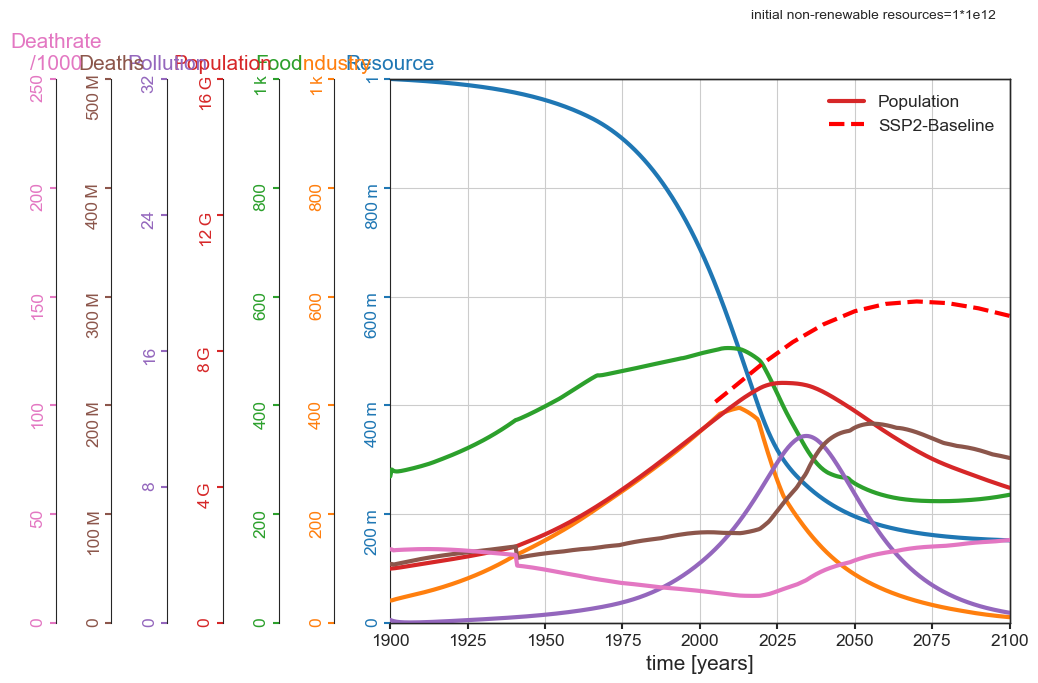

In [9]:
world3 = World3(year_max=maxyear)  # default value for nri_factor is 1
run_and_plot(world3)
# plt.savefig("world3_timeseries_case_1.png",transparent=True,bbox_inches="tight",dpi=300)

Initially, industrial production (rising orange), food per capita (rising green) and population (rising red) experience growth. However, as non-renewable resources start rapidly decline (falling blue), industrial production begins to decline (falling orange). This decline subsequently causes a decrease in food production (falling green), which causes an increase in the death rate (rising pink) and a decline in population (falling red) during the latter half of the 21st century. This scenario is resource-constrained because the collapse in growth that occured in the middle of the 21st century was initially driven by a decline in available resources.

For comparison, the red dashed line represents the population projection for the IPCC baseline scenario of SSP2, a 'Middle of the road' scenario in which current trends continue (effecively the business-as-usual SSP scenario). Note the difference with the population projection of `world3`'s BAU scenario. While a priori unclear, the origin of this discrepancy likely arises from the different values that were chosen for the many parameters as well as which components and interactions were assumed when designing a world model or IAM. One obvious difference is the assumption of continued economic growth (decoupled from resource use) in SSP2. The large prediction uncertainty inherent in this modelling activity limits its predictive power. However, characteristic mechanisms (e.g. feedback pathways) are shared across these very different models and imply characteristic phenomena (e.g. population saturation).

## Section 3.2: *BAU3* - An Abundant Resource Scenario

The previous scenario was resource-constrained, as the collapse in growth was driven by the limited available resources in the middle of the 21st century. In this section you will create a scenario that is not purely resource-constrained by initializing the `pyworld3` with triple the initial non-renewable resources of the *BAU* scenario. As such, let's call this new scenario *BAU3*.

### Coding Exercise 3.2

To create the *BAU3* scenario you will need to triple the initial resources (`nri_factor`). Tripling the initial resources could represent the effect of increased efficiency in resource extraction via approaches such as changes in crop yields (as has been observed over recent decades), or the "learning-by-doing" effect that productivity is achieved through practice and innovations (as seen in the economics of many energy technologies). 

**Based on the input parameters of the `run_and_plot()` function discussed above, run the *BAU3* scenario and plot the output.** 

In [10]:
# Uncomment below and fill in ellipses
# run_and_plot(world3, ...)
# plt.savefig("world3_timeseries_case_2.png",transparent=True,bbox_inches="tight",dpi=300)

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/solutions/W2D3_Tutorial1_Solution_6fea4765.py)

*Example output:*

<img alt='Solution hint' align='left' width=950.0 height=683.0 src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/static/W2D3_Tutorial1_Solution_6fea4765_2.png>



Notice that the decline in industrial production (orange) still occurs in this scenario, but it is delayed by a few decades due to the larger initial resource pool (blue). However, unlike the previous case that was resource-constrained, the extended period of exponential industrial growth (orange) in this scenario leads to a significant increase in pollution (purple). As a result, the population crash (red), which is now driven by both increased pollution (purple) and diminishing resources (blue), is faster and more substantial than the *BAU* scenario's population crash.

In this BAU3 scenario, the population growth and crash more closely resembles the population projection for the IPCC baseline scenario of SSP2 than the BAU scenario, but there is still a contrast between the two population projections. 

## Section 3.3: *BAU3* with an Active Cap on Production

In the BAU and BAU3 scenarios, we assessed the impact of changes in initial resource availability (`nri_factor`). However, another important variable to consider is the lifetime of industrial capital (`new_lifetime_industrial_capital`). Economic growth is likely to result in increaesd energy demand, but it's essential to find a way to avoid high levels of climate warming while also meeting the growing world energy demands. To do so would require rapidly transforming current capital infrastructure in our energy system so that it relies on technologies that produce significantly less greenhouse gas emissions. For further details of IAM transitioning with reductions in lifetime capital see [Rozenberg et al. *Environ. Res. Lett.* (2015)](https://iopscience.iop.org/article/10.1088/1748-9326/10/9/095006/pdf).

In this section, you will assess the effects of reducing the lifetime of industrial capital. We will use the same BAU3 scenario with triple the initial resources, but will adjust the `new_lifetime_industrial_capital` variable to reflect a reduced lifetime of industrial capital. Specifically, this scenario turn down production abruptly via a step decrease in the lifetime of industrial capital, by imposing a reduction from 14 to 8 years in 2025.

c:\Users\jajohns\mambaforge\envs\env2023a\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


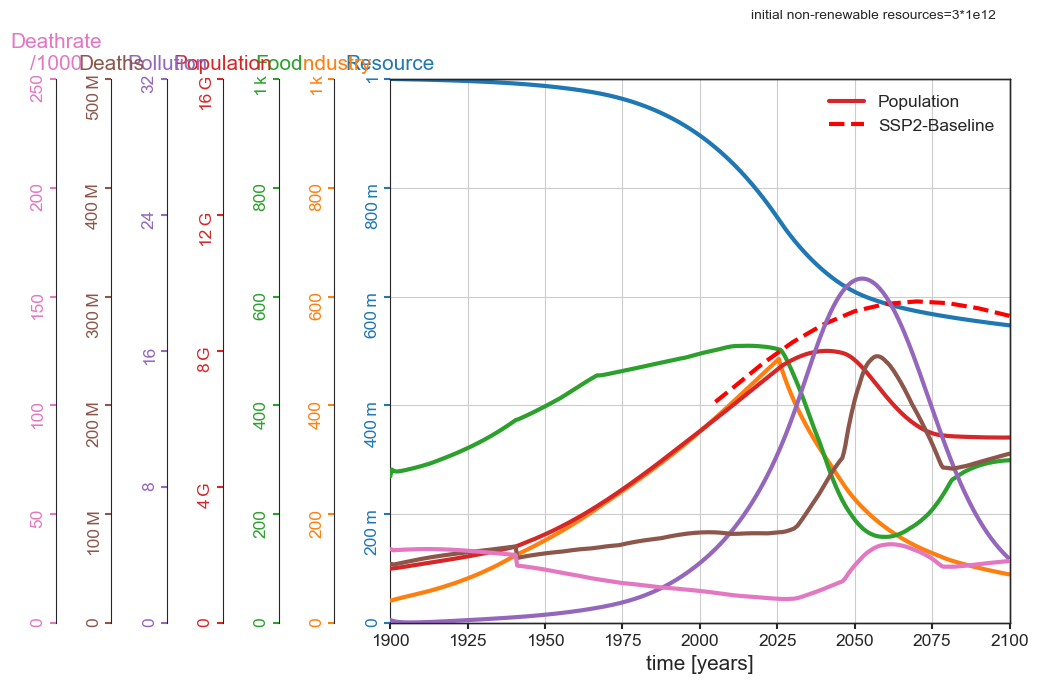

In [11]:
world3 = World3(pyear=2025, year_max=2100)
run_and_plot(world3, nri_factor=3, new_lifetime_industrial_capital=8)
# plt.savefig("world3_timeseries_case_3.png",transparent=True,bbox_inches="tight",dpi=300)

Notice that by reducing production (orange), pollution levels are also reduced (purple), which in turn limits the decline in population to a plateau (red). This approach preserves a significant amount of non-renewable resource (blue). However, over time, the asymptotic death rate (pink) gradually increases, approaching that of the BAU3 scenario without the reduced production. As a result, the population plateau is not sustained, and the population continues to decline slowly beyond the year 2100.

Additionally, dropping industrial output (as we did in this scenario) negatively impacts our ability to develop new technologies, e.g. those needed for decarbonization (c.f. the article [Decarbonizing the downturn: Addressing climate change in an age of stagnation by Copley, 2022](https://journals.sagepub.com/doi/full/10.1177/10245294221120986). This stagnation scenario is a central challenge faced in the narrative of Shared Socio-economic Pathway 3 (SSP3 *Regional Rivary*).

### Questions 3.3:
1. What scenarios might lead to a drop in the lifetime of industrial capital?
2. What are some important features of the world, society, and/or economy that are missing in this model?

[*Click for solution*](https://github.com/neuromatch/climate-course-content/tree/main/tutorials/W2D3_FutureClimate-IPCCII&IIISocio-EconomicBasis/solutions/W2D3_Tutorial1_Solution_4f5777c0.py)



## Section 3.4: Validity and Limitations of `pyworld3`

Validity analyses for `pyworld3` are presented in the `pyworld3` github repository. For example, shown below is the `pyworld3` standard run simulation output (shown in the same colors we've been using throughout this tutorial) compared to the original World3 model output (shown in black):

In [12]:
display(Image(url="https://github.com/cvanwynsberghe/pyworld3/raw/main/img/result_standard_run.png", width=250))

Overall, the `pyworld3` simulation output replicates well the original World3 simulation.

Note that there are limitations to the `world3` model that are important to remember:

- There is no spatial structure. Spatial structure is important, as it allows for distinct regional solutions that aid or hinder global cooperation
- The model ignores technology innovation, including innovations in adaptation and mitigation
- There is an *ad hoc* relationship between economic growth, investment in health services, and changes in life expectancy
- The model only includes a monolithic non-renewable resource (e.g. doesn't break down the resource into renewable and non-renewable classes)

# Summary
In this tutorial, you explored a socio-economic model based on resource extraction. This is the conceptual basis of the world models within IAMs used in IPCC projections. 

You examined this interplay through `World3`, a *World model* which is a class of model similar to IAMs. You followed several variable dependency pathways within this model to identify some positive and negative feedback loops, and then you used this model to simulate 3 future scenarios which varied in their amount of initially available non-renewable resources and the lifetime of capital. Through these simulations you explored the factors driving current population growth, and its future projected decline or stabilization. In particular, you found rapid resource consumption can have negative impacts by exhausting these resources and/or by increasing pollution and reducing human health, thus highlighting the potential threats of unregulated resource extraction on a finite planet.

Finally, you learned about some of the limitations of models like `World3`, as they don't include some important natural and socio-economic variables. By exploring these complex concepts, you are now better equipped to engage with discussions on climate change, resource management, and sustainable economic growth.

# Resources

The data for the IAMs used in this tutorial, as well as the main simulations of the IAMs used in the IPCC reports can be accessed h[here](https://tntcat.iiasa.ac.at/SspDb/dsd). 

The `pyworld3` model and data used in this tutorial can be accessed [here](https://github.com/cvanwynsberghe/pyworld3).